In [1]:
import pairtools
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
from NGS import HiCTools as HT
from collections import defaultdict

In [2]:
#Set up the environment
environment_name = 'cooltools_09'
environment_path = f"/users/federico.teloni/.conda/envs/{ environment_name }/bin/"

In [3]:
# get pre-set PATH environment variable
original_os_path = os.environ.get('PATH')
os_path = original_os_path

#guard PATH against multiple prepending
if environment_path not in original_os_path:
    os_path = environment_path + ':' + original_os_path

%env PATH=$os_path

env: PATH=/users/federico.teloni/.conda/envs/cooltools_09/bin/:/software/system/jupyter/vbc_conda/bin:/software/2020/software/anaconda3/2019.03:/software/2020/software/anaconda3/2019.03/sbin:/software/2020/software/anaconda3/2019.03/bin:/software/system/utils:/sbin:/bin:/usr/sbin:/usr/bin


In [4]:
import gzip

In [5]:
#Define plotting parameters
matplotlib.rcParams.update({"pdf.fonttype": 42})

In [6]:
#Define functions
def recDict():
    return defaultdict(recDict)

In [38]:
#results directory
resultsDir = "/groups/gerlich/experiments/Experiments_004900/004999/plots/Scaling_plots/"

In [29]:
#Define samples
parDir = "/groups/gerlich/experiments/Experiments_004900/004999/NovaSeq/4962-Novaseq/s4t_merged_pairsam/"

pairDir = {"WT_UT": parDir,
           "GGCTAC_S17": parDir,
           "WT_5Gy_2h": parDir,
           "Sororin_5GY_2h": parDir,
           "G2": parDir,
           "Sor_TTAGGC": parDir
          }


sampleMap = {"WT_UT": "WT_untreated",
             "GGCTAC_S17": "WT 5Gy 15m recovery",
             "WT_5Gy_2h": "WT 5Gy 2h recovery",
             "Sororin_5GY_2h": "Sororin-depleted 5Gy 2h recovery",
             "G2": "G2 Michael's", 
             "Sor_TTAGGC": "Sororin-depleted Michael's"
            }

In [30]:
#Load samples
pairs = {}
for barcode, name in sampleMap.items():
    pairs[name] = {}
    pairs[name]["cis"] = HT.loadPairs(os.path.join(pairDir[barcode], f"{barcode}.cis.pairs.gz"))
    pairs[name]["trans"] = HT.loadPairs(os.path.join(pairDir[barcode], f"{barcode}.trans.pairs.gz"))

In [33]:
#Downsample pairs
pairsNew = HT.downSamplePairs(pairs, Distance=1000)

In [34]:
#Get chromosome features
hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

In [35]:
#Calculate scaling plots
scs = {sample: {rType: pairlib.scalings.compute_scaling(
    pairsNew[sample][rType],
    arms,
    hg19_chromsizes
) for rType in ["cis", "trans"]}
          for sample in pairsNew.keys()
}

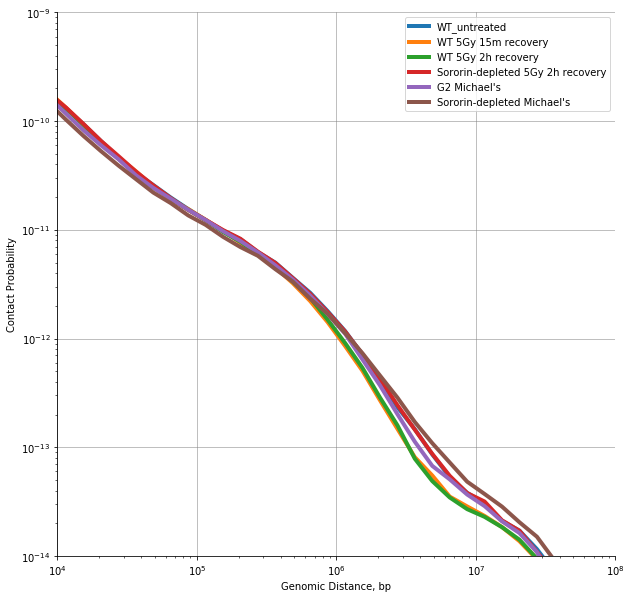

In [50]:
#Plot results cis contacts
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

f, ax = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.7)
for index, sample in enumerate(pairsNew.keys()):
    for rType in ["cis"]:
        sc = scs[sample][rType]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax.loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            sc_agg.n_pairs / sc_agg.n_bp2,
            label=f'{sample}',
            linewidth=4)
    ax.grid(lw=0.5, color='gray')
    ax.set_xlim(10**4, 10**8)
    ax.set_ylim(10**-14, 10**-9)
    ax.legend()
    ax.set_xlabel("Genomic Distance, bp")
    ax.set_ylabel("Contact Probability")
f.set_size_inches(10, 10)
sbn.despine()
plt.show()

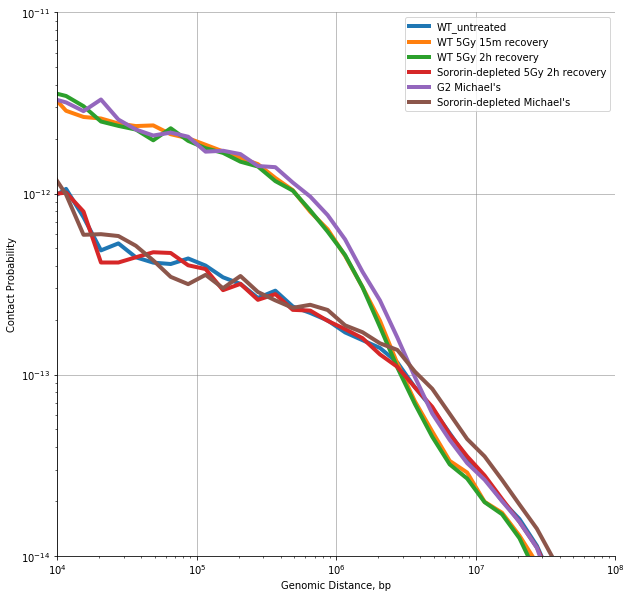

In [55]:
f, ax = plt.subplots(1, 1)
plt.subplots_adjust(wspace=0.7)
for index, sample in enumerate(pairsNew.keys()):
    for rType in ["trans"]:
        sc = scs[sample][rType]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax.loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            sc_agg.n_pairs / sc_agg.n_bp2,
            label=f'{sample}',
            linewidth=4)
    ax.grid(lw=0.5, color='gray')
    ax.set_xlim(10**4, 10**8)
    ax.set_ylim(10**-14, 10**-11)
    ax.legend()
    ax.set_xlabel("Genomic Distance, bp")
    ax.set_ylabel("Contact Probability")
f.set_size_inches(10, 10)
sbn.despine()
plt.show()